# Visualization over the NYC map

## References:

- Adding a background map to plots:  
[https://geopandas.org/en/stable/gallery/plotting_basemap_background.html](https://geopandas.org/en/stable/gallery/plotting_basemap_background.html)

In [121]:
import warnings
warnings.filterwarnings('ignore')
import os
import datetime
import zipfile
import pandas as pd
import geopandas
import contextily as cx
import seaborn as sns
import matplotlib.pyplot as plt
from pyproj import Proj, transform

In [75]:
def cleaning(df, user_type=None, add_user_age=True):

    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '')

    df = df.dropna(subset=['birthyear'])
    
    if user_type is not None:
        assert user_type in ['Subscriber', 'Customer']
        df = df.query('usertype==@user_type')

    df = df.query('startstationlongitude!=0')
    df = df.query('startstationlatitude!=0')
    df = df.query('endstationlongitude!=0')
    df = df.query('endstationlatitude!=0')

    df.loc[:, 'starttime'] = pd.to_datetime(df.starttime)
    df.loc[:, 'stoptime'] = pd.to_datetime(df.stoptime)
    df.loc[:, 'year'] = df.starttime.dt.year
    df.loc[:, 'hour'] = df.starttime.dt.hour
    df.loc[:, 'weekday'] = df.starttime.dt.weekday.astype(str).str.cat(
        df.starttime.dt.day_name().str[:3], sep='-')
    df.loc[:, 'weekday-hour'] = df.hour.astype(str).str.cat(
        df.starttime.dt.day_name().str[:3], sep='-')

    if add_user_age:
        df.loc[:, 'user_age'] = df.year - df.birthyear
        df = df.query('user_age>=0')
        df = df.query('user_age<=80')

    return df

In [30]:
def load_data(date=None, date_from=None, date_to=None, clean=True):
    """
        date: (str) e.g., '201701'
    """

    if date is not None:
        zip_file = zipfile.ZipFile(f'../rawdata/{date}-citibike-tripdata.csv.zip')
        data = pd.read_csv(zip_file.open(zip_file.namelist()[0]))
        # data = pd.read_csv(f'../rawdata/{date}-citibike-tripdata.csv.zip', compression='zip')
        if clean:
            return cleaning(data)
        else:
            return data

    else:
        if date_from is not None and date_to is not None:
            return pd.concat([load_data(date=date.strftime("%Y%m"))
                for date in pd.date_range(start=date_from, end=date_to, freq='M')])
        else:
            return None

In [31]:
df = load_data(date='201701')
df.head()

,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,bikeid,usertype,birthyear,gender,year,hour,weekday,weekday-hour,user_age
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226,W 82 St & Central Park West,40.782750,-73.971370,3165,Central Park West & W 72 St,40.775794,-73.976206,25542,Subscriber,1965.0,2,2017,0,6-Sun,0-Sun,52.0
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263,Cooper Square & E 7 St,40.729236,-73.990868,498,Broadway & W 32 St,40.748549,-73.988084,21136,Subscriber,1987.0,2,2017,0,6-Sun,0-Sun,30.0
5,666,2017-01-01 00:01:51,2017-01-01 00:12:57,3163,Central Park West & W 68 St,40.773407,-73.977825,3163,Central Park West & W 68 St,40.773407,-73.977825,16050,Subscriber,2000.0,1,2017,0,6-Sun,0-Sun,17.0
6,559,2017-01-01 00:05:00,2017-01-01 00:14:20,499,Broadway & W 60 St,40.769155,-73.981918,479,9 Ave & W 45 St,40.760193,-73.991255,27294,Subscriber,1973.0,1,2017,0,6-Sun,0-Sun,44.0
7,826,2017-01-01 00:05:37,2017-01-01 00:19:24,362,Broadway & W 37 St,40.751726,-73.987535,445,E 10 St & Avenue A,40.727408,-73.981420,23288,Subscriber,1977.0,2,2017,0,6-Sun,0-Sun,40.0


## Samples

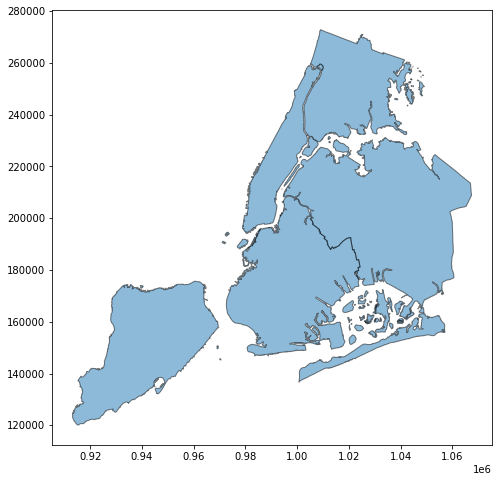

In [33]:
gdf = geopandas.read_file(geopandas.datasets.get_path('nybb'))
ax = gdf.plot(figsize=(8, 8), alpha=0.5, edgecolor='k')

In [42]:
gdf

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


In [34]:
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

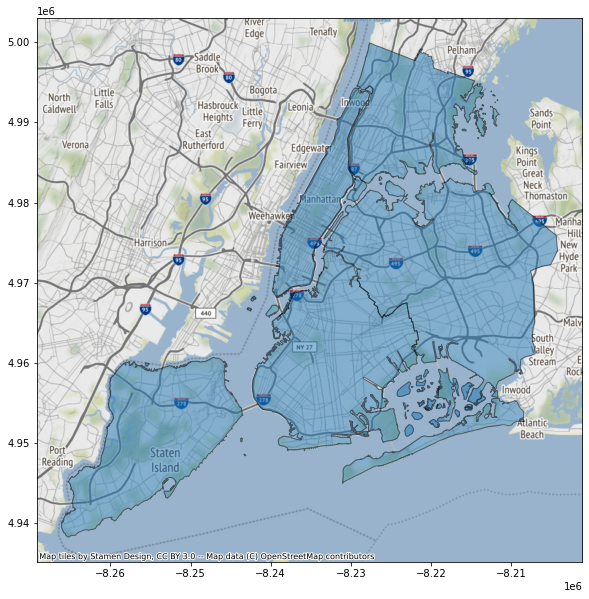

In [67]:
df_wm = gdf.to_crs(epsg=3857)
ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax)

## Plot scatters over NYC map

In [76]:
df = load_data(date='201701')
df.head()

,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,bikeid,usertype,birthyear,gender,year,hour,weekday,weekday-hour,user_age
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226,W 82 St & Central Park West,40.782750,-73.971370,3165,Central Park West & W 72 St,40.775794,-73.976206,25542,Subscriber,1965.0,2,2017,0,6-Sun,0-Sun,52.0
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263,Cooper Square & E 7 St,40.729236,-73.990868,498,Broadway & W 32 St,40.748549,-73.988084,21136,Subscriber,1987.0,2,2017,0,6-Sun,0-Sun,30.0
5,666,2017-01-01 00:01:51,2017-01-01 00:12:57,3163,Central Park West & W 68 St,40.773407,-73.977825,3163,Central Park West & W 68 St,40.773407,-73.977825,16050,Subscriber,2000.0,1,2017,0,6-Sun,0-Sun,17.0
6,559,2017-01-01 00:05:00,2017-01-01 00:14:20,499,Broadway & W 60 St,40.769155,-73.981918,479,9 Ave & W 45 St,40.760193,-73.991255,27294,Subscriber,1973.0,1,2017,0,6-Sun,0-Sun,44.0
7,826,2017-01-01 00:05:37,2017-01-01 00:19:24,362,Broadway & W 37 St,40.751726,-73.987535,445,E 10 St & Avenue A,40.727408,-73.981420,23288,Subscriber,1977.0,2,2017,0,6-Sun,0-Sun,40.0


In [83]:
def my_transform(df):
    lon = df.iloc[1]
    lat = df.iloc[0]
    # Available for CitiBike dataset
    return transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), lat, lon)

In [84]:
my_transform(df.loc[0, ['startstationlongitude', 'startstationlatitude']])


(-8234455.241680832, 4980349.95684253)

In [91]:
geo_specific_size = df.groupby(['startstationlongitude', 'startstationlatitude']).size().rename('size').reset_index()
geo_specific_size

,startstationlongitude,startstationlatitude,size
0,-74.017134,40.708347,1261
1,-74.016777,40.705693,1361
2,-74.016588,40.646538,67
3,-74.016584,40.715338,2529
4,-74.016510,40.646768,67
...,...,...,...
602,-73.935775,40.686312,319
603,-73.935610,40.743000,111
604,-73.935404,40.744697,105
605,-73.934903,40.681460,104


In [99]:
transformed_geo = geo_specific_size[['startstationlongitude', 'startstationlatitude']].apply(my_transform, axis=1)
transformed_geo = transformed_geo.rename('geo_info').reset_index()
transformed_geo

,index,geo_info
0,0,"(-8239549.716951268, 4969417.622975491)"
1,1,"(-8239509.909101359, 4969027.821274087)"
2,2,"(-8239488.856829298, 4960345.120709503)"
3,3,"(-8239488.389930594, 4970444.306524348)"
4,4,"(-8239480.20349524, 4960378.811537391)"
...,...,...
602,602,"(-8230492.824406046, 4966182.280184676)"
603,603,"(-8230474.456690066, 4974507.808481788)"
604,604,"(-8230451.4970450895, 4974757.204909035)"
605,605,"(-8230395.753810075, 4965469.9871312)"


In [111]:
geo_specific_size['trans_lon'], geo_specific_size['trans_lat'] = zip(*transformed_geo.geo_info)
geo_specific_size

,startstationlongitude,startstationlatitude,size,trans_lon,trans_lat
0,-74.017134,40.708347,1261,-8.239550e+06,4.969418e+06
1,-74.016777,40.705693,1361,-8.239510e+06,4.969028e+06
2,-74.016588,40.646538,67,-8.239489e+06,4.960345e+06
3,-74.016584,40.715338,2529,-8.239488e+06,4.970444e+06
4,-74.016510,40.646768,67,-8.239480e+06,4.960379e+06
...,...,...,...,...,...
602,-73.935775,40.686312,319,-8.230493e+06,4.966182e+06
603,-73.935610,40.743000,111,-8.230474e+06,4.974508e+06
604,-73.935404,40.744697,105,-8.230451e+06,4.974757e+06
605,-73.934903,40.681460,104,-8.230396e+06,4.965470e+06


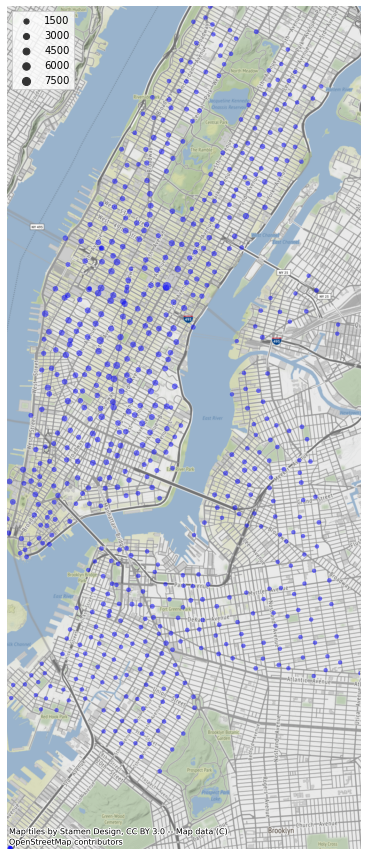

In [176]:
fig, ax = plt.subplots(figsize=(10, 12))
df_wm = gdf.to_crs(epsg=3857)
ax = sns.scatterplot(data=geo_specific_size,
    x='trans_lon', y='trans_lat', alpha=0.5, size='size', color='blue', edgecolor='none')
ax.legend(fancybox=False)
ax.axis('off')
ax.margins(0)
cx.add_basemap(ax)
fig.tight_layout()
fig.savefig('sample-map.pdf', bbox_inches='tight', pad_inches=0)

In [180]:
def plot_size_on_nyc(df, ax, alpha=0.5, color='blue', edgecolor='none'):

    geo_specific_size = df.groupby(['startstationlongitude', 'startstationlatitude']).size().rename('size').reset_index()
    transformed_geo = geo_specific_size[['startstationlongitude', 'startstationlatitude']].apply(my_transform, axis=1)
    transformed_geo = transformed_geo.rename('geo_info').reset_index()
    geo_specific_size['trans_lon'], geo_specific_size['trans_lat'] = zip(*transformed_geo.geo_info)

    # fig, ax = plt.subplots(figsize=(10, 12))
    ax = sns.scatterplot(data=geo_specific_size, ax=ax,
        x='trans_lon', y='trans_lat', size='size',
        alpha=alpha, color=color, edgecolor=edgecolor)

    ax.legend(fancybox=False)
    ax.axis('off')
    ax.margins(0)
    cx.add_basemap(ax)
    # fig.tight_layout()
    # fig.savefig('sample-map.pdf', bbox_inches='tight', pad_inches=0)

    return ax

<AxesSubplot:xlabel='trans_lon', ylabel='trans_lat'>

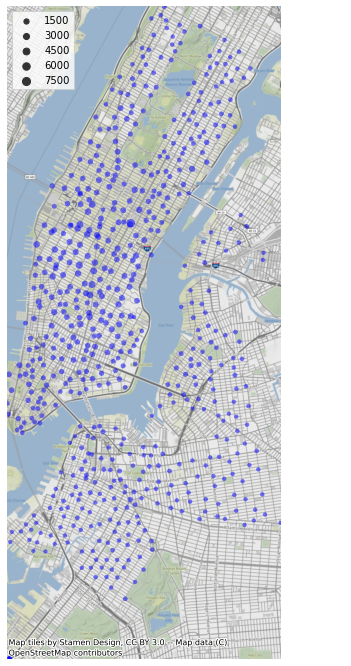

In [181]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_size_on_nyc(df, ax)